In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit

In [3]:
merch_850_chargeback = pd.read_csv('data/int20h-main-2025/merchant_8508273933093481573/chargebacks.csv')
merch_850_fraud = pd.read_csv('data/int20h-main-2025/merchant_8508273933093481573/fraud_alerts.csv')
order_850_path = 'data/int20h-main-2025/merchant_8508273933093481573/orders'
merch_855_chargeback = pd.read_csv('data/int20h-main-2025/merchant_8558295590389402168/chargebacks.csv')
merch_855_fraud = pd.read_csv('data/int20h-main-2025/merchant_8558295590389402168/fraud_alerts.csv')
order_855_path = 'data/int20h-main-2025/merchant_8558295590389402168/orders'
merch_1101_chargeback = pd.read_csv('data/int20h-main-2025/merchant_11019390644840797009/chargebacks.csv')
merch_1101_fraud = pd.read_csv('data/int20h-main-2025/merchant_11019390644840797009/fraud_alerts.csv')
order_1101_path = 'data/int20h-main-2025/merchant_11019390644840797009/orders'

In [4]:
def path_to_df(path):
    orders_path = path
    csv_files = [f for f in os.listdir(orders_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(os.path.join(orders_path, file), low_memory=False) for file in csv_files]
    df_orders = pd.concat(df_list, ignore_index=True)
    df_orders["created_at"] = pd.to_datetime(df_orders["created_at"]).dt.date
    df_orders = df_orders[['transaction_id', 'created_at']]
    return df_orders

In [5]:
def create_series_dataset(example, context_length, output_length):
    X,y = [],[]
    for i in range(len(example)-context_length-output_length):
        try:
            feature=example[i:i+context_length]
            target=example[i+context_length:i+context_length+output_length]
            if len(feature) != context_length:
                continue
            X.append(feature)
            y.append(target)
        except:
            print('nah, 1 batch missed')
    return X,y

In [6]:
def process_data(df_tr, df_af, df_ch):
    df_tr["created_at"] = pd.to_datetime(df_tr["created_at"]).dt.date
    df_af["created_at"] = pd.to_datetime(df_af["created_at"]).dt.date
    df_ch["created_at"] = pd.to_datetime(df_ch["created_at"]).dt.date
    df_tr = df_tr[['transaction_id', 'created_at']]
    sum_fraud = df_af['created_at'].value_counts()
    sum_chargeback = df_ch['created_at'].value_counts()
    sum_orders = df_tr['created_at'].value_counts()
    sum_orders = pd.merge(sum_orders, sum_fraud, on = 'created_at', how = 'left').fillna(0)
    sum_orders = pd.merge(sum_orders, sum_chargeback, on = 'created_at', how = 'left').fillna(0)
    sum_orders = sum_orders.reset_index()
    sum_orders.rename(columns = {'index':'created_at', 'count_x': 'orders', 'count_y' : 'fraud', 'count': 'cb'}, inplace = True)
    sum_orders["fraud"] = sum_orders["fraud"]+ sum_orders["cb"]
    df = sum_orders
    risk_ratios = []
    ratios = [[], [], [], []]
    weekdays = []
    for i, row in df.iterrows():
        date_limit = row['created_at']
        recent_data = df[(df['created_at'] < date_limit) & (df['created_at'] >= date_limit - pd.Timedelta(days=30))]
        recent_data_15 = df[(df['created_at'] < date_limit) & (df['created_at'] >= date_limit - pd.Timedelta(days=15))]
        recent_data_7 = df[(df['created_at'] < date_limit) & (df['created_at'] >= date_limit - pd.Timedelta(days=7))]
        recent_data_3 = df[(df['created_at'] < date_limit) & (df['created_at'] >= date_limit - pd.Timedelta(days=3))]
        orders_in_last_15 = recent_data_15['orders'].sum()
        oreders_in_last_7 = recent_data_7['orders'].sum()
        oreders_in_last_3 = recent_data_3['orders'].sum()
        orders_in_last_0 = row['orders']
        fraud_in_last_30_days = recent_data['fraud'].sum()
        orders_in_last_30_days = recent_data['orders'].sum()
        l = [orders_in_last_30_days, orders_in_last_15, oreders_in_last_7, oreders_in_last_3]
        weekdays.append(row['created_at'].weekday())
        if i>30 & orders_in_last_30_days > 0:
            ratios[0].append(orders_in_last_30_days / orders_in_last_0)
        else:
            ratios[0].append(0)

        if i>15 & orders_in_last_15 > 0:
            ratios[1].append(orders_in_last_15 / orders_in_last_0)
        else:
            ratios[1].append(0)

        if i>7 &oreders_in_last_7 > 0:
            ratios[2].append(oreders_in_last_7 / orders_in_last_0)
        else:
            ratios[2].append(0)

        if i>3 &oreders_in_last_3 > 0:
            ratios[3].append(oreders_in_last_3 / orders_in_last_0)
        else:
            ratios[3].append(0)

        if orders_in_last_30_days > 0:
            risk_ratio = (fraud_in_last_30_days / orders_in_last_30_days)
        else:
            risk_ratio = 0
        risk_ratios.append(risk_ratio)

    df[f"spec_feat_0"] = ratios[0]
    df[f"spec_feat_1"] = ratios[1]
    df[f"spec_feat_2"] = ratios[2]
    df[f"spec_feat_3"] = ratios[3]
    df['risk_event_ratio'] = risk_ratios
    df["day_of_week"] = weekdays
    return df


In [7]:
def multidem_squz(example):
    return np.vstack(np.dstack(example)).T

In [8]:
def train_n_submissionfile(premade = False, single_mode = True):
    models = []
    merch_ids = ['8508273933093481573', '8558295590389402168', '11019390644840797009']
    merch_sets =[[merch_850_chargeback, merch_850_fraud, order_850_path],
                 [merch_855_chargeback,merch_855_fraud, order_855_path],
                 [merch_1101_chargeback, merch_1101_fraud, order_1101_path]]
    params = {
        "objective": "reg:squarederror",
        "max_depth": 12,
        "learning_rate": 0.06,
        "random_state": 42,
    }
    if single_mode == True:
        if premade == True:
            X_trains, X_tests, y_trains, y_tests = [], [], [], []
            X_train, X_test, y_train, y_test = [0,1,2], [0,1,2], [0,1,2], [0,1,2]
            for i in range(3):
                print(i, "data")
                df = pd.read_csv(f"{merch_ids[i]}_ratios_new.csv")
                df["gaus"] = gaussian_filter1d(df["risk_event_ratio"],sigma = 15, mode ='reflect')
                df["gaus_2"] = gaussian_filter1d(df["risk_event_ratio"],sigma = 15, mode ='reflect')
                df["SMA"] = df["risk_event_ratio"].rolling(window=15).mean()
                df["SMA_2"] = df["risk_event_ratio"].rolling(window=5).mean()
                df["EMA"] = df["risk_event_ratio"].ewm(alpha=0.2).mean()
                features = ["risk_event_ratio", "spec_feat_0","spec_feat_1", "spec_feat_2", "spec_feat_3"]#"gaus", "SMA", "EMA"]
                X, y = create_series_dataset(np.array(df[features]), 220, 182)
                y= [data[:, 0] for data in y]
                if i!=0:
                    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X, y, test_size = 0.3, random_state = 42)
                    X_trains.extend(X_train[i])
                    y_trains.extend(y_train[i])
                    X_tests.extend(X_test[i])
                    y_tests.extend(y_test[i])
                if i ==0:
                    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X, y, test_size = 0.3, random_state = 42)
                    dtrain = xgb.DMatrix(multidem_squz(X_train[i]), label=np.array(y_train[i]))
                    model_low_var = xgb.train(params, dtrain, num_boost_round=200)

            dtrain = xgb.DMatrix(multidem_squz(X_trains), label=np.array(y_trains))
            model = xgb.train(params, dtrain, num_boost_round=200)

            for i in range(3):
                if i==0:
                    dtest = xgb.DMatrix(multidem_squz(X_test[i]))
                    y_pred = model_low_var.predict(dtest)
                else:
                    dtest = xgb.DMatrix(multidem_squz(X_test[i]))
                    y_pred = model.predict(dtest)
                print(len(X_test[i]))
                print(f"test_{merch_ids[i]}: {r2_score(y_test[i], y_pred)}")

            dtest = xgb.DMatrix(multidem_squz(X_tests))
            y_pred = model.predict(dtest)
            print(f"test_all: {r2_score(y_tests, y_pred)}")

            return model, model_low_var
        else:
            print("nyyy, tyt sche ni4ogo ne zrobleno")
    else:
        for i in range(3):
            if premade == True:
                print('premade')
                df = pd.read_csv(f"{merch_ids[i]}_ratios_new.csv")

            else:
                df = process_data(path_to_df(merch_sets[i][2]), merch_sets[i][0], merch_sets[i][1])
                df["created_at"] = pd.to_datetime(df["created_at"])
                df.sort_values("created_at", inplace = True)
                df.to_csv(f"{merch_ids[i]}_ratios_new.csv", index=False)

            features = ["risk_event_ratio", "spec_feat_0","spec_feat_1", "spec_feat_2", "spec_feat_3"]

            X, y = create_series_dataset(np.array(df[features]), 220, 182)
            y= [data[:, 0] for data in y]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
            dtrain = xgb.DMatrix(multidem_squz(X_train), label=y_train)
            dtest = xgb.DMatrix(multidem_squz(X_test))
            model = xgb.train(params, dtrain, num_boost_round=500)
            y_pred = model.predict(dtest)
            print(r2_score(y_test, y_pred))
            models.append(model)

    return models


In [11]:
models_from_function = []
models_from_function = train_n_submissionfile(premade = True, single_mode = False)
#omni_model, omni_low_model = train_n_submissionfile(premade = True, single_mode = True)
#reve_df = train_n_submissionfile(premade = True)

premade
0.7452241778373718
premade
0.9278834462165833
premade
0.9348193407058716


In [12]:
def create_submit_file(models,premade = True, single_mode = True):
    submits = []
    merch_ids = ['8508273933093481573', '8558295590389402168', '11019390644840797009']
    merch_sets =[[merch_850_chargeback, merch_850_fraud, order_850_path],
                 [merch_855_chargeback,merch_855_fraud, order_855_path],
                 [merch_1101_chargeback, merch_1101_fraud, order_1101_path]]

    for i in range(3):
        print(i)
        if single_mode == True:
            model = models
            if premade == True:
                df = pd.read_csv(f"{merch_ids[i]}_ratios_new.csv")
                X,_ = create_series_dataset(np.array(df['risk_event_ratio'])[-220:], 220, 0)

            else:
                print("create_submit_file duro4ka :(")
        else:
            model = models[i]
            if premade == True:
                df = pd.read_csv(f"{merch_ids[i]}_ratios_new.csv")
                X,_ = create_series_dataset(np.array(df['spec_feat_0'])[-220:], 220, 0)
            else:
                df = process_data(path_to_df(merch_sets[i][2]), merch_sets[i][0], merch_sets[i][1])
                df["created_at"] = pd.to_datetime(df["created_at"])
                df.sort_values("created_at", inplace = True)
                X, _ = create_series_dataset(df[-220:], 220, 0)

        dx = xgb.DMatrix(np.array([X]))
        y_pred = model.predict(dx)*100
        submit_df = pd.DataFrame(y_pred.squeeze(), columns=['prediction'])
        list = []
        for x in range(182):
            date_ymd = pd.to_datetime('2024-08-12')+pd.Timedelta(days=x)
            name = f"{merch_ids[i]}_{date_ymd.date()}"
            list.append(name)

        submit_df["merchant_id_day"] = list
        submits.append(submit_df)
    return submits

In [15]:
submisions = create_submit_file(models_from_function, single_mode = False)
#submision = create_submit_file(omni_model)

0
1
2


In [16]:
#submit_file = pd.concat(submision)
#submit_file.to_csv('submisions_lagging_9_w_days.csv', index=False)

submit_file = pd.concat(submisions)
submit_file.to_csv("submit_file_models_fixed.csv", index = False)

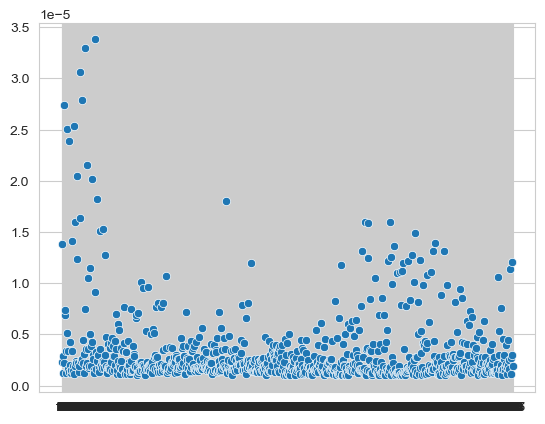

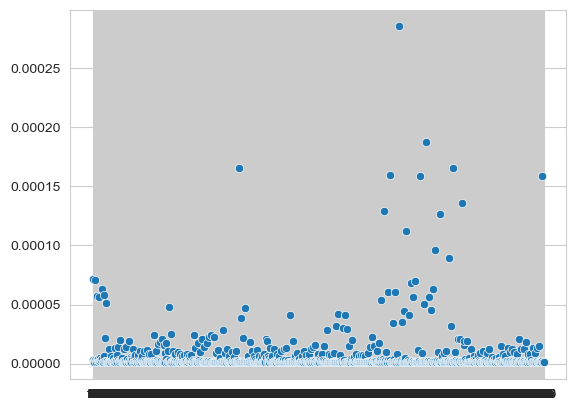

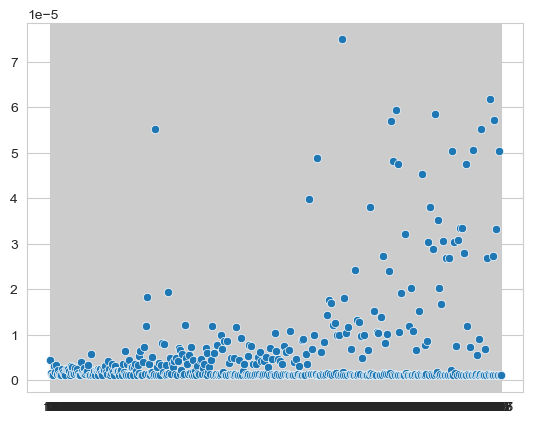

In [13]:
for model in models_from_function:
    sns.scatterplot(model.get_score(importance_type='gain'))
    plt.show()

In [14]:
len(models_from_function[0].get_score(importance_type='gain'))

883